## Importing packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tweepy
import requests
import os
import json
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
response = requests.get("https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv")
with open("image_predictions.tsv", mode="wb") as f:
    f.write(response.content)
image_prediction = pd.read_csv("image_predictions.tsv", sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
with open('tweet_json.txt') as f:
    additional_data = pd.DataFrame((json.loads(line) for line in f), columns = ['id', 'favorite_count', 'retweet_count'])

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



## `twitter_archive`

In [5]:
twitter_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


> Note :  **Tidiness**
- Dogs steps : Bad representation of the dogs steps values, where there is a tidiness problem (4 columns `doggo, floofer, pupper, puppo`) represent the same column which is : **dog step**
- `rating_numerator` and `rating_denominator` should be in one column called `rating`.


**PS :** we can remove the column `rating_denominator`(since all denominators are '/10') and leave the column `rating_numerator` by changing its name to more descriptif name like `rating_(x/10)` 


> Note :  **Quality**
- Change column name `rating_numerator`into `rating_numerator_(/10)`
- Missing values in `doggo, floofer, pupper, puppo` are noted as None instead of NaN

In [6]:
twitter_archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [7]:
twitter_archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [8]:
twitter_archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [9]:
twitter_archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [10]:
existing_values = 0
for col in ['doggo', 'floofer', 'pupper', 'puppo']:
    existing_values += twitter_archive[col].value_counts()[1]
    
len(twitter_archive) - existing_values

1962

> Note :  **Quality**
- 1962 **dog step** missing values in 

In [11]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

> Note :  **Quality**
- `timestamp` dtype should be datetime64 instead of pandas object (string)
- dog steps column (after dealing with the tidiness problem) should be categorial

In [12]:
twitter_archive.head().timestamp

0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
2    2017-07-31 00:18:03 +0000
3    2017-07-30 15:58:51 +0000
4    2017-07-29 16:00:24 +0000
Name: timestamp, dtype: object

> Note :  **Quality**
- `timesstamp` column values contain **+0000** at the end

In [13]:
tweets_with_missing_images_index = twitter_archive[twitter_archive['expanded_urls'].isnull()].index
print(f'Number of tweets with missing urls : {len(tweets_with_missing_images_index)} ')

Number of tweets with missing urls : 59 


In [14]:
reply_tweets_index = np.array(twitter_archive[~twitter_archive['in_reply_to_status_id'].isnull()].index)
retweets_index = np.array(twitter_archive[~twitter_archive['retweeted_status_id'].isnull()].index)
none_original_tweets_index = np.union1d(reply_tweets_index, retweets_index)
print(f'Number of none original tweets (retweets) : {len(none_original_tweets_index)} ')

Number of none original tweets (retweets) : 259 


> Note : **Quality**
Because we are asked to keep only the ratings (no retweets, replies...) that have images (a.k.a have urls), therefore any none original tweet or any tweets with missing images (`expanded_urls`) should be deleted.

> Drop none original tweets : means dropping all rows with existing values in columns :
`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `in_reply_to_user_id`, `retweeted_status_timestamp`.

> Explanation: Tweets with `in_reply_to_status_id`, `in_reply_to_user_id` values are considered replies a.k.a None original tweets, and tweets with `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` are considered as retweets a.k.a none original values, therefore these tweets should be dropped.

- Drop tweets with no images a.k.a missing `expanded_urls`

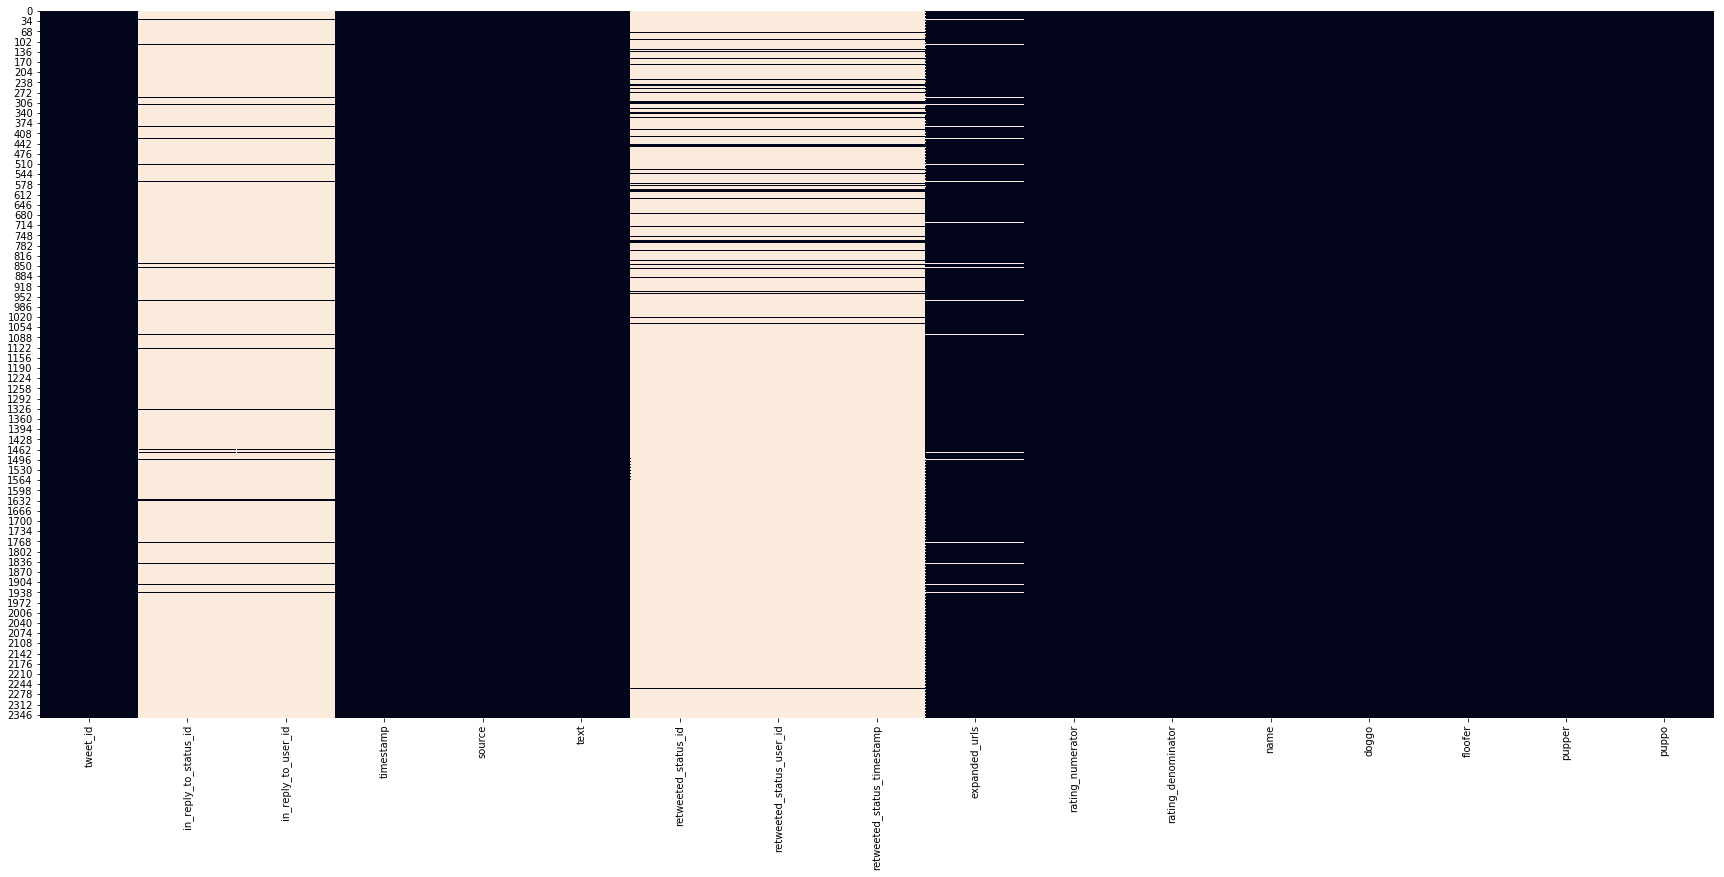

In [15]:
plt.figure(figsize=(30, 13))
sns.heatmap(twitter_archive.isna(), cbar=False)
plt.show()

> Note : 
- Missing values in columns = `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `in_reply_to_user_id`, `retweeted_status_timestamp`, along with few missing values in some rows

In [16]:
twitter_archive.tweet_id.duplicated().sum()

0

> Note :   No duplicate tweets

In [17]:
twitter_archive.name.value_counts()

None         745
a             55
Charlie       12
Lucy          11
Oliver        11
Cooper        11
Tucker        10
Lola          10
Penny         10
Winston        9
Bo             9
Sadie          8
the            8
Daisy          7
Toby           7
Buddy          7
an             7
Bailey         7
Oscar          6
Leo            6
Scout          6
Bella          6
Jax            6
Stanley        6
Dave           6
Jack           6
Milo           6
Koda           6
Rusty          6
Bentley        5
            ... 
Tessa          1
Jim            1
Shooter        1
Edd            1
Donny          1
Charleson      1
Torque         1
Cilantro       1
Rhino          1
Lambeau        1
Kulet          1
River          1
Anthony        1
Eriq           1
JD             1
Biden          1
Remy           1
Augie          1
Sailor         1
Mookie         1
Tove           1
space          1
Eazy           1
Cedrick        1
Banjo          1
Teddy          1
Patch          1
Kona          

In [18]:
twitter_archive.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja',
       'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose',
       'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra',
       'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn',
       'Boomer', 'Cody', 'Rumble', 'Clifford', 'quite', 'Dewey', 'Scout',
       'Gizmo', 'Cooper', 'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy',
       'Meatball', 'Paisley', 'Albus', 'Neptune', '

> Note :  **Quality**
- 745 missing values for the column `name`, this latter is noted as None instead of NaN
- 55 dog named: **'a'** which is completely wrong (no dog named 'a', even if it would, there's no way that 55 dogs are named this way), therefore it must be wrong)

In [19]:
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

> Note :  **Quality**
- These values are **html code**, I considered extracting and checking the urls in these values (even though they are duplicated a lot). After checking the extracted urls, I concluded that these urls are useless. Therefore this column is useless and should be dropped

## `image_prediction`

In [20]:
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [21]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


> Note :  No missing values 

> Note :  **Quality**
- `p1`, `p2`, `p3` dtypes should be categrial

In [22]:
image_prediction[['p1_conf', 'p2_conf', 'p3_conf']].describe()

,p1_conf,p2_conf,p3_conf
count,2075.000000,2.075000e+03,2.075000e+03
mean,0.594548,1.345886e-01,6.032417e-02
std,0.271174,1.006657e-01,5.090593e-02
min,0.044333,1.011300e-08,1.740170e-10
25%,0.364412,5.388625e-02,1.622240e-02
50%,0.588230,1.181810e-01,4.944380e-02
75%,0.843855,1.955655e-01,9.180755e-02
max,1.000000,4.880140e-01,2.734190e-01


> Note :  As we see the first prediction is always better than the second and the third predictions. then comes the second one the the third one.

> Note :  **Quality**
- rename columns : `p1`, `p2`, `p3`              **to**        `class_1`, `class_2`, `class_3`
- rename columns : `p1_conf`, `p2_conf`, `p3_conf`      **to**     `class_1_conf`, `class_2_conf`, `class_3_conf`
- rename columns : `p1_dog`, `p2_dog`, `p3_dog`     **to**       `p1_purebred_dog`, `p2_purebred_dog`, `p3_purebred_dog`

In [23]:
image_prediction.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
Staffordshire_bullterrier     20
German_shepherd               20
Siberian_husky                20
Cardigan                      19
web_site                      19
Maltese_dog                   18
beagle                        18
Eskimo_dog                    18
Shetland_sheepdog             18
teddy                         18
Shih-Tzu                      17
Rottweiler                    17
Lakeland_terrier              17
kuvasz                        16
Italian_greyhound             16
          

In [24]:
image_prediction.p1.unique()

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher', 'Bernese_mountain_dog',
       'box_turtle', 'chow', 'shopping_cart', 'miniature_poodle',
       'golden_retriever', 'Gordon_setter', 'Walker_hound', 'pug',
       'bloodhound', 'Lhasa', 'English_setter', 'hen', 'desktop_computer',
       'Italian_greyhound', 'Maltese_dog', 'three-toed_sloth', 'ox',
       'malamute', 'guinea_pig', 'soft-coated_wheaten_terrier',
       'Chihuahua', 'black-and-tan_coonhound', 'coho', 'toy_terrier',
       'Blenheim_spaniel', 'Pembroke', 'llama', 'Chesapeake_Bay_retriever',
       'curly-coated_retriever', 'dalmatian', 'Ibizan_hound',
       'Border_collie', 'Labrador_retriever', 'seat_belt', 'snail',
       'miniature_schnauzer', 'Airedale', 'triceratops', 'swab', 'hay',
       'hyena', 'jigsaw_puzzle', 'West_Highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'vacuum', 'Rottweiler',
       'Siberian_husky', 'teddy', 

> Note :  **Quality**
- dog classes contains `_` instead of `space`
- Weird and wrong dog classes such us : shopping_cart, desktop_computer, guinea_pig, llama, seat_belt, snail...etc

## `additional_data`

In [25]:
additional_data.head()

,id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


In [26]:
additional_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


> Note :  **Tidiness**
- column `id` should be `tweet_id` 

In [27]:
additional_data.describe()

,id,favorite_count,retweet_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,8080.968564,3164.797366
std,6.852812e+16,11814.771334,5284.770364
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,1415.000000,624.500000
50%,7.194596e+17,3603.500000,1473.500000
75%,7.993058e+17,10122.250000,3652.000000
max,8.924206e+17,132810.000000,79515.000000


In [28]:
additional_data.id.duplicated().sum()

0

In [29]:
len(additional_data)

2354

### Quality issues
#### `twitter_archive`
-  `1#` `timestamp` column values contain **+0000** at the end
- `2#` `timestamp` dtype should be datetime64 instead of pandas object (string)
- `3#` 745 missing values for the column `name`, this latter is noted as None instead of NaN
- `4#` Wrong dog `name`s: **'a'**
- `6#` Missing values in `doggo, floofer, pupper, puppo` are noted as None instead of NaN
- `7#` dog steps column (after dealing with the tidiness problem) should be categorial
- `8#` Drop none original tweets
- `9#` Drop tweets with no images a.k.a missing `expanded_urls`
- `10#` Delete columns = `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`,     `in_reply_to_user_id`, `retweeted_status_timestamp` after using them in detecting none original tweets
- `11#` `source` column is useless and should be dropped


#### `image_prediction`
- `1#` rename columns : `p1`, `p2`, `p3`              **to**        `class_1`, `class_2`, `class_3`
- `2#` rename columns : `p1_conf`, `p2_conf`, `p3_conf`      **to**     `class_1_conf`, `class_2_conf`, `class_3_conf`
- `3#` rename columns : `p1_dog`, `p2_dog`, `p3_dog`     **to**       `class_1_purebred_dog`, `class_2_purebred_dog`, `class_3_purebred_dog`
- `4#` Weird and wrong dog classes such us : shopping_cart, desktop_computer, guinea_pig, llama, seat_belt, snail...etc


### Tidiness issues
- `1#`  The 4 columns `doggo, floofer, pupper, puppo` represent the same column which is : **dog_step**
- `2#` `rating_numerator` and `rating_denominator` should be in one column called `rating_(x/10)`
- `3#`  column `id` should be `tweet_id` in `additional_data`
- `4#` `additional_data` & `image_prediction`should be a part of `twitter_archive` 

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [30]:
# Make copies of original pieces of data
twitter_archive_clean = twitter_archive.copy()
image_prediction_clean = image_prediction.copy()
additional_data_clean = additional_data.copy()

### Overview

In [31]:
twitter_archive_clean.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1370,702321140488925184,NaN,NaN,2016-02-24 02:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please enjoy this picture as much as I did. 12...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/702321140...,12,10,None,None,None,None,None
539,806576416489959424,NaN,NaN,2016-12-07 19:09:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Hooman catch successful. Massive hit by dog. F...,NaN,NaN,NaN,https://twitter.com/deadspin/status/8065709331...,13,10,None,None,None,None,None
1307,707315916783140866,NaN,NaN,2016-03-08 21:23:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Finnegus. He's trapped in a snow globe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707315916...,10,10,Finnegus,None,None,pupper,None
1290,708130923141795840,NaN,NaN,2016-03-11 03:22:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please stop sending in non canines like this G...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/708130923...,11,10,None,None,None,None,None
1649,683742671509258241,NaN,NaN,2016-01-03 20:12:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sebastian. He's a womanizer. Romantic af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683742671...,11,10,Sebastian,None,None,None,None
900,758740312047005698,NaN,NaN,2016-07-28 19:06:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Boston. He's worried because his tongue w...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758740312...,12,10,Boston,None,None,None,None
308,835574547218894849,NaN,NaN,2017-02-25 19:37:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Eli. He works backstage at Bone Jovi c...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835574547...,11,10,Eli,None,None,None,None
683,788412144018661376,NaN,NaN,2016-10-18 16:11:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dexter. He breaks hearts for a living....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/788412144...,11,10,Dexter,None,None,None,None
2087,670797304698376195,NaN,NaN,2015-11-29 02:51:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Trigger. He was minding his own busine...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670797304...,11,10,Trigger,None,None,None,None
86,875747767867523072,NaN,NaN,2017-06-16 16:11:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Goose. He's a womanizer. Cheeky as h*c...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/875747767...,13,10,Goose,None,None,None,None


In [32]:
image_prediction_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [33]:
additional_data_clean.head()

,id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


## `twitter_archive_clean`

### Quality issue #1:  `timesstamp` column values contain **+0000** at the end 

#### Define:
Remove **+0000** at the end of `timesstamp` column values

#### Code

In [34]:
twitter_archive_clean.timestamp = twitter_archive_clean.timestamp.str[:-6]

#### Test

In [35]:
twitter_archive_clean.head().timestamp

0    2017-08-01 16:23:56
1    2017-08-01 00:17:27
2    2017-07-31 00:18:03
3    2017-07-30 15:58:51
4    2017-07-29 16:00:24
Name: timestamp, dtype: object

### Quality issue #2: `timestamp` dtype should be datetime64 instead of pandas object (string)

#### Define :
Change `timestamp` column type to datatime64

#### Code

In [36]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

#### Test

In [37]:
twitter_archive_clean.timestamp.dtype

dtype('<M8[ns]')

### Quality issue #3: 745 missing values for the column `name`, this latter is noted as None instead of NaN 

#### Define :
Replace **'None'** `name` values by **Numpy NaN**


#### Code

In [38]:
twitter_archive_clean.name.replace({'None': np.NaN}, inplace=True)

#### Test

In [39]:
twitter_archive_clean.name.value_counts()

a            55
Charlie      12
Lucy         11
Oliver       11
Cooper       11
Tucker       10
Lola         10
Penny        10
Winston       9
Bo            9
Sadie         8
the           8
Daisy         7
Buddy         7
Toby          7
an            7
Bailey        7
Milo          6
Scout         6
Jack          6
Jax           6
Koda          6
Bella         6
Leo           6
Stanley       6
Oscar         6
Rusty         6
Dave          6
Bentley       5
Phil          5
             ..
Tessa         1
Jim           1
Shooter       1
Edd           1
Donny         1
Charleson     1
Torque        1
Cilantro      1
Rhino         1
Lambeau       1
Kulet         1
River         1
Anthony       1
Eriq          1
JD            1
Biden         1
Remy          1
Augie         1
Sailor        1
Mookie        1
Tove          1
space         1
Eazy          1
Cedrick       1
Banjo         1
Teddy         1
Patch         1
Kona          1
Tanner        1
Mack          1
Name: name, Length: 956,

### Quality issue #4: Wrong dog `name`s: **'a'**

#### Define :
Replace dods named **'a'** with **Numpy NaN**

#### Code

In [40]:
twitter_archive_clean.name.replace({'a': np.NaN}, inplace=True)

#### Test

In [41]:
twitter_archive_clean.name.value_counts()

Charlie      12
Lucy         11
Oliver       11
Cooper       11
Tucker       10
Lola         10
Penny        10
Bo            9
Winston       9
the           8
Sadie         8
an            7
Daisy         7
Bailey        7
Buddy         7
Toby          7
Rusty         6
Koda          6
Stanley       6
Jax           6
Bella         6
Scout         6
Jack          6
Dave          6
Oscar         6
Milo          6
Leo           6
Chester       5
Phil          5
Bentley       5
             ..
Tessa         1
Jim           1
Shooter       1
Edd           1
Donny         1
Charleson     1
Torque        1
Cilantro      1
Rhino         1
Lambeau       1
Kulet         1
River         1
Anthony       1
Eriq          1
JD            1
Biden         1
Remy          1
Augie         1
Sailor        1
Mookie        1
Tove          1
space         1
Eazy          1
Cedrick       1
Banjo         1
Teddy         1
Patch         1
Kona          1
Tanner        1
Mack          1
Name: name, Length: 955,

### Tidiness issue #1: The 4 columns `doggo, floofer, pupper, puppo` represent the same column which is : **dog_step**

### Quality issue `6#`: Missing values in `doggo, floofer, pupper, puppo` are noted as None instead of NaN

#### Define : 
Extract the `dog_step` value from columns `doggo, floofer, pupper, puppo` into a new column called `dog_step`
Using inside the function return **np.nan** when the `dog_step` value is missing using a function and apply it on the dataset.

#### Code

In [42]:
# Defining a fuction to extract the dog_step values and return them
def dog_step(df):
    if df['doggo'] == 'doggo':
        return 'doggo'
    elif df['floofer'] == 'floofer':
        return 'floofer'
    elif df['pupper'] == 'pupper':
        return 'pupper'
    elif df['puppo'] == 'puppo':
        return 'puppo'
    else:
        return np.nan

In [43]:
# Applying the function 
twitter_archive_clean['dog_step'] = twitter_archive_clean.apply(dog_step, axis=1)

In [44]:
# Dropping `doggo, floofer, pupper, puppo` columns
twitter_archive_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

#### Test

In [45]:
# Tidiness test
twitter_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_step
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo


In [46]:
# Replacing None with np.nan check

In [47]:
twitter_archive_clean.dog_step.unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer'], dtype=object)

In [48]:
# checking columns dropping
twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_step'],
      dtype='object')

###  Quality issue `7#`: `dog_step` column (after dealing with the tidiness problem) should be categorial 

#### Define :
Change `dog_step` column type to **categorial**

#### Code

In [49]:
twitter_archive_clean["dog_step"] = twitter_archive_clean["dog_step"].astype("category")

#### Test

In [50]:
twitter_archive_clean.dog_step.dtype

CategoricalDtype(categories=['doggo', 'floofer', 'pupper', 'puppo'], ordered=False)

### Quality issue `11#`: `source` column is useless and should be dropped

#### Define :
Drop `source` column

#### Code

In [51]:
twitter_archive_clean.drop('source', axis=1, inplace=True)

#### Test

In [52]:
twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_step'],
      dtype='object')

### Quality issue `8#`:  Drop none original tweets
### Quality issue `9#`: Drop tweets with no images a.k.a missing `expanded_urls`

> Drop none original tweets : means dropping all rows with existing values in columns :
`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `in_reply_to_user_id`, `retweeted_status_timestamp`.

> Explanation: Tweets with `in_reply_to_status_id`, `in_reply_to_user_id` values are considered replies a.k.a None original tweets, and tweets with `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` are considered as retweets a.k.a none original values, therefore these tweets should be dropped.

- Drop tweets with no images a.k.a missing `expanded_urls`

#### Define :

- Tweets with `in_reply_to_status_id`, `in_reply_to_user_id` values are considered replies a.k.a None original tweets.

- Tweets with `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` are considered as retweets a.k.a none original values.

**Therefore these tweets should be dropped.**

> **How** :
After listing the indexes of none original tweets **none_original_tweets_index** in the 'define' phase, we can use these indexes to drop tweets with drop these tweets. Same for the tweets with no images using the indexes **tweets_with_missing_images_index**

#### Code

In [53]:
# The indexes of none original tweets
none_original_tweets_index

array([  19,   30,   32,   36,   55,   64,   68,   73,   74,   78,   91,
         95,   97,  101,  109,  113,  118,  124,  130,  132,  137,  146,
        148,  149,  155,  159,  160,  165,  171,  179,  180,  182,  184,
        185,  186,  188,  189,  194,  195,  204,  211,  212,  218,  222,
        228,  230,  231,  234,  247,  250,  251,  260,  266,  272,  273,
        274,  281,  285,  286,  289,  290,  291,  298,  302,  303,  307,
        309,  310,  313,  319,  327,  332,  340,  341,  342,  343,  346,
        357,  359,  366,  382,  386,  387,  397,  399,  406,  409,  411,
        415,  420,  422,  425,  427,  431,  434,  435,  438,  446,  447,
        450,  453,  455,  462,  465,  469,  475,  476,  479,  485,  488,
        498,  506,  513,  522,  530,  535,  538,  541,  543,  546,  552,
        555,  558,  561,  565,  566,  568,  570,  574,  576,  577,  581,
        583,  586,  589,  594,  595,  596,  597,  598,  599,  600,  601,
        602,  603,  604,  605,  606,  611,  612,  6

In [54]:
# The indexes of tweets with mssing images ()
tweets_with_missing_images_index

Int64Index([  30,   55,   64,  113,  148,  179,  185,  186,  188,  189,  218,
             228,  234,  274,  290,  291,  313,  342,  346,  375,  387,  409,
             427,  498,  513,  570,  576,  611,  701,  707,  843,  857,  967,
            1005, 1080, 1295, 1345, 1445, 1446, 1474, 1479, 1497, 1523, 1598,
            1605, 1618, 1663, 1689, 1774, 1819, 1844, 1895, 1905, 1914, 1940,
            2038, 2149, 2189, 2298],
           dtype='int64')

In [55]:
# Dataset len before dropping tweets
before = len(twitter_archive_clean)
# Combining tweets_with_missing_images_index & none_original_tweets_index
tweets_to_be_dropped_arr = np.union1d(none_original_tweets_index, tweets_with_missing_images_index)
tweets_to_be_dropped_index = tweets_to_be_dropped_arr.tolist()
# Dropping tweets
twitter_archive_clean.drop(index=tweets_to_be_dropped_index, inplace=True)

#### Test

In [56]:
before, len(twitter_archive_clean)

(2356, 2094)

### Quality issue `10#`: Delete columns = `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`,     `in_reply_to_user_id`, `retweeted_status_timestamp` after using them in detecting none original tweets

#### Define :
Since we're done with detecting and dropping unwanted tweets, now we can drop the columns: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`,     `in_reply_to_user_id`, `retweeted_status_timestamp` since that there's no need for keeping them now.

#### Code

In [57]:
twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id',
                            'in_reply_to_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [58]:
twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_step'],
      dtype='object')

### Tidiness issue `2#`:  `rating_numerator` and `rating_denominator` should be in one column called `rating_(x/10)`

#### Define :
Drop the column `rating_denominator` and rename the column  `rating_numerator` to `rating_(x/10)`

#### Code

In [59]:
# Dropping column 'rating_denominator'
twitter_archive_clean.drop('rating_denominator', axis=1, inplace=True)
# Renaming column 'rating_numerator'
twitter_archive_clean.rename(columns={'rating_numerator': 'rating_(x/10)'}, inplace=True)

#### Test

In [60]:
twitter_archive_clean.head()

,tweet_id,timestamp,text,expanded_urls,rating_(x/10),name,dog_step
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,NaN


In [61]:
# Stroring the cleaned dataset
twitter_archive_clean.to_csv('twitter_archive_clean.csv', index=False)

## `image_prediction_clean`

### Quality issues:
- `1#` rename columns : `p1`, `p2`, `p3`              **to**        `class_1`, `class_2`, `class_3`
- `2#` rename columns : `p1_conf`, `p2_conf`, `p3_conf`      **to**     `class_1_conf`, `class_2_conf`, `class_3_conf`
- `3#` rename columns : `p1_dog`, `p2_dog`, `p3_dog`     **to**       `p1_purebred_dog`, `p2_purebred_dog`, `p3_purebred_dog`

#### Define :
Rename columns : `p1`, `p2`, `p3`              **to**        `class_1`, `class_2`, `class_3`

Rename columns : `p1_conf`, `p2_conf`, `p3_conf`      **to**     `class_1_conf`, `class_2_conf`, `class_3_conf`

Rename columns : `p1_dog`, `p2_dog`, `p3_dog`     **to**       `class_1_purebred_dog`, `class_2_purebred_dog`, `class_3_purebred_dog`

#### Code

In [62]:
image_prediction_clean.rename(columns={'p1': 'class1', 'p2': 'class2', 'p3': 'class3', 
                                      'p1_conf': 'class_1_conf', 'p2_conf': 'class_2_conf', 'p3_conf': 'class_3_conf', 
                                      'p1_dog': 'class_1_purebred_dog', 'p2_dog': 'class_2_purebred_dog', 'p3_dog': 'class_3_purebred_dog'},
                              inplace=True)

#### Test

In [63]:
image_prediction_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'class1', 'class_1_conf',
       'class_1_purebred_dog', 'class2', 'class_2_conf',
       'class_2_purebred_dog', 'class3', 'class_3_conf',
       'class_3_purebred_dog'],
      dtype='object')

### Quality issue- `4#`:  Weird and wrong dog classes such us : shopping_cart, desktop_computer, guinea_pig, llama, seat_belt, snail...etc

#### Define :
- Make a copy of for predictions, and work on them  
- Clean classes columns values
- Read scrapped txt files and clean them
- Use these dog_breeds file to determine which values aren't accurate
- Replace Inaccurate values with with np.nan
- Use the first prediction as the main prediction
- Replacing missing values in class1 by the next best prediction (class2, class3), if all predictions are missing it stays NaN
- Use purebred file to classify dog breeds to purebred and none purebred
- drop old prediction columns from the dataset and replace them with the new ones containing one correct prediction and one correction decision about purity of the dog breed


> Explanation: 
Because we've multiple predictions for the same image we can just keep the best prediction which is **p1_class** since it has the highest **conf**. But since we have some obviously wrong **p1_class** predictions we can replace with the second highest **conf** prediction.
This way we will not only deal with the tidiness problems, we will also deal with the both missing and inaccurate predictions (a.k.a classes) values

#### Code

In [64]:
# Make a copy for the predictions
prediction = image_prediction_clean[['tweet_id', 'class1', 'class_1_conf',
       'class_1_purebred_dog', 'class2', 'class_2_conf',
       'class_2_purebred_dog', 'class3', 'class_3_conf',
       'class_3_purebred_dog']]

#### Test

In [65]:
prediction.columns

Index(['tweet_id', 'class1', 'class_1_conf', 'class_1_purebred_dog', 'class2',
       'class_2_conf', 'class_2_purebred_dog', 'class3', 'class_3_conf',
       'class_3_purebred_dog'],
      dtype='object')

In [66]:
# Cleaning all classes values
for c in ['class1', 'class2', 'class3']:
    prediction[c] = prediction[c].str.replace('_', ' ')
    prediction[c] = prediction[c].str.replace('-', ' ')
    prediction[c] = prediction[c].str.lower()

#### Test

In [67]:
prediction.class1.unique()

array(['welsh springer spaniel', 'redbone', 'german shepherd',
       'rhodesian ridgeback', 'miniature pinscher', 'bernese mountain dog',
       'box turtle', 'chow', 'shopping cart', 'miniature poodle',
       'golden retriever', 'gordon setter', 'walker hound', 'pug',
       'bloodhound', 'lhasa', 'english setter', 'hen', 'desktop computer',
       'italian greyhound', 'maltese dog', 'three toed sloth', 'ox',
       'malamute', 'guinea pig', 'soft coated wheaten terrier',
       'chihuahua', 'black and tan coonhound', 'coho', 'toy terrier',
       'blenheim spaniel', 'pembroke', 'llama', 'chesapeake bay retriever',
       'curly coated retriever', 'dalmatian', 'ibizan hound',
       'border collie', 'labrador retriever', 'seat belt', 'snail',
       'miniature schnauzer', 'airedale', 'triceratops', 'swab', 'hay',
       'hyena', 'jigsaw puzzle', 'west highland white terrier',
       'toy poodle', 'giant schnauzer', 'vizsla', 'vacuum', 'rottweiler',
       'siberian husky', 'teddy', 

In [68]:
# Reading txt file scrapped from wikipedia contains all dog breeds and the second one contains all purebreds
with open('wiki_dog_breed_list.txt', 'r') as f:
    dog_breeds = [line.strip() for line in f]
with open('purebred.txt', 'r') as f:
    purebred = [line.strip() for line in f]

#### Test

In [69]:
dog_breeds

['Affenpinscher[7]',
 'Afghan Hound[8]',
 'Africanis[9]',
 'Aidi[10]',
 'Airedale Terrier[11]',
 'Akbash[12]',
 'Akita[13]',
 'Aksaray Malaklisi',
 'Alano Español[14]',
 'Alapaha Blue Blood Bulldog[15]',
 'Alaskan husky[16]',
 'Alaskan Klee Kai[17]',
 'Alaskan Malamute[18]',
 'Alopekis',
 'Alpine Dachsbracke[19]',
 'American Bulldog[20]',
 'American Bully',
 'American Cocker Spaniel[21]',
 'American English Coonhound[22]',
 'American Eskimo Dog[23]',
 'American Foxhound[24]',
 'American Hairless Terrier[25]',
 'American Pit Bull Terrier[26]',
 'American Staffordshire Terrier[26]',
 'American Water Spaniel[27]',
 'Andalusian Hound[28]',
 'Anglo-Français de Petite Vénerie[29]',
 'Appenzeller Sennenhund[30]',
 'Ariegeois[31]',
 'Armant[32]',
 'Armenian Gampr dog',
 'Artois Hound[33]',
 'Assyrian Mastiff',
 'Australian Cattle Dog[34]',
 'Australian Kelpie[34]',
 'Australian Shepherd[35]',
 'Australian Stumpy Tail Cattle Dog[36]',
 'Australian Terrier[37]',
 'Austrian Black and Tan Hound[38

In [70]:
purebred

['Affenpinscher[7]',
 'Afghan Hound[8]',
 'Africanis[9]',
 'Aidi[10]',
 'Airedale Terrier[11]',
 'Akbash[12]',
 'Akita[13]',
 'Aksaray Malaklisi',
 'Alano Español[14]',
 'Alapaha Blue Blood Bulldog[15]',
 'Alaskan husky[16]',
 'Alaskan Klee Kai[17]',
 'Alaskan Malamute[18]',
 'Alopekis',
 'Alpine Dachsbracke[19]',
 'American Bulldog[20]',
 'American Bully',
 'American Cocker Spaniel[21]',
 'American English Coonhound[22]',
 'American Eskimo Dog[23]',
 'American Foxhound[24]',
 'American Hairless Terrier[25]',
 'American Pit Bull Terrier[26]',
 'American Staffordshire Terrier[26]',
 'American Water Spaniel[27]',
 'Andalusian Hound[28]',
 'Anglo-Français de Petite Vénerie[29]',
 'Appenzeller Sennenhund[30]',
 'Ariegeois[31]',
 'Armant[32]',
 'Armenian Gampr dog',
 'Artois Hound[33]',
 'Assyrian Mastiff',
 'Australian Cattle Dog[34]',
 'Australian Kelpie[34]',
 'Australian Shepherd[35]',
 'Australian Stumpy Tail Cattle Dog[36]',
 'Australian Terrier[37]',
 'Austrian Black and Tan Hound[38

In [71]:
# Function for Cleaning and adjisting the list of dog breeds
def scrapped_dog_list_cleaner(lst):
    special_chars = {'ü':'u', 'ä':'a', 'ö':'o', 'ž':'z', 'ý':'y', 'é':'e', 'ñ':'n', "'": ' ', '-': ' ', }
    dog_breeds_cleaned = []
    for dog_breed in lst:
        dog_breed = dog_breed.lower()
        if '[' in dog_breed:
            dog_breed = dog_breed[0:dog_breed.rindex('[')]
            for special_char in special_chars.keys():
                if special_char in dog_breed:
                    dog_breed = dog_breed.replace(special_char, special_chars.get(special_char))
        dog_breeds_cleaned.append(dog_breed)
    return dog_breeds_cleaned

In [72]:
# Applying function
dog_breeds_cleaned = scrapped_dog_list_cleaner(dog_breeds)

In [73]:
# Applying function
purebred = scrapped_dog_list_cleaner(purebred)

#### Test

In [74]:
dog_breeds_cleaned

['affenpinscher',
 'afghan hound',
 'africanis',
 'aidi',
 'airedale terrier',
 'akbash',
 'akita',
 'aksaray malaklisi',
 'alano espanol',
 'alapaha blue blood bulldog',
 'alaskan husky',
 'alaskan klee kai',
 'alaskan malamute',
 'alopekis',
 'alpine dachsbracke',
 'american bulldog',
 'american bully',
 'american cocker spaniel',
 'american english coonhound',
 'american eskimo dog',
 'american foxhound',
 'american hairless terrier',
 'american pit bull terrier',
 'american staffordshire terrier',
 'american water spaniel',
 'andalusian hound',
 'anglo français de petite venerie',
 'appenzeller sennenhund',
 'ariegeois',
 'armant',
 'armenian gampr dog',
 'artois hound',
 'assyrian mastiff',
 'australian cattle dog',
 'australian kelpie',
 'australian shepherd',
 'australian stumpy tail cattle dog',
 'australian terrier',
 'austrian black and tan hound',
 'austrian pinscher',
 'azawakh',
 'bakharwal dog',
 'banjara hound',
 'barbado da terceira',
 'barbet',
 'basenji',
 'basque she

In [75]:
purebred

['affenpinscher',
 'afghan hound',
 'africanis',
 'aidi',
 'airedale terrier',
 'akbash',
 'akita',
 'aksaray malaklisi',
 'alano espanol',
 'alapaha blue blood bulldog',
 'alaskan husky',
 'alaskan klee kai',
 'alaskan malamute',
 'alopekis',
 'alpine dachsbracke',
 'american bulldog',
 'american bully',
 'american cocker spaniel',
 'american english coonhound',
 'american eskimo dog',
 'american foxhound',
 'american hairless terrier',
 'american pit bull terrier',
 'american staffordshire terrier',
 'american water spaniel',
 'andalusian hound',
 'anglo français de petite venerie',
 'appenzeller sennenhund',
 'ariegeois',
 'armant',
 'armenian gampr dog',
 'artois hound',
 'assyrian mastiff',
 'australian cattle dog',
 'australian kelpie',
 'australian shepherd',
 'australian stumpy tail cattle dog',
 'australian terrier',
 'austrian black and tan hound',
 'austrian pinscher',
 'azawakh',
 'bakharwal dog',
 'banjara hound',
 'barbado da terceira',
 'barbet',
 'basenji',
 'basque she

In [76]:
# Replacing missing values in class1 by the next best prediction (class2, class3), if all predictions are missing it stays NaN
def class_cleaner(df):
    if df['class1'] in dog_breeds_cleaned:
        return df['class1']
    else:
        if df['class2'] in dog_breeds_cleaned:
            return df['class2']
        else:
            if df['class3'] in dog_breeds_cleaned:
                return df['class3']
            else:
                return np.NaN

In [77]:
# Applying the function
prediction['dog_class'] = prediction.apply(class_cleaner, axis=1)

In [78]:
prediction

,tweet_id,class1,class_1_conf,class_1_purebred_dog,class2,class_2_conf,class_2_purebred_dog,class3,class_3_conf,class_3_purebred_dog,dog_class
0,666020888022790149,welsh springer spaniel,0.465074,True,collie,0.156665,True,shetland sheepdog,0.061428,True,shetland sheepdog
1,666029285002620928,redbone,0.506826,True,miniature pinscher,0.074192,True,rhodesian ridgeback,0.072010,True,miniature pinscher
2,666033412701032449,german shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,german shepherd
3,666044226329800704,rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature pinscher,0.222752,True,rhodesian ridgeback
4,666049248165822465,miniature pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True,miniature pinscher
5,666050758794694657,bernese mountain dog,0.651137,True,english springer,0.263788,True,greater swiss mountain dog,0.016199,True,bernese mountain dog
6,666051853826850816,box turtle,0.933012,False,mud turtle,0.045885,False,terrapin,0.017885,False,NaN
7,666055525042405380,chow,0.692517,True,tibetan mastiff,0.058279,True,fur coat,0.054449,False,tibetan mastiff
8,666057090499244032,shopping cart,0.962465,False,shopping basket,0.014594,False,golden retriever,0.007959,True,golden retriever
9,666058600524156928,miniature poodle,0.201493,True,komondor,0.192305,True,soft coated wheaten terrier,0.082086,True,komondor


In [79]:
# Function to classify dog breeds into purebred (true) and not purebred (false)
def purebred_cleaner(df):
    if pd.isnull(df['dog_class']):
        return np.NaN
    else:
        if df['dog_class'] in purebred:
            return True
        else:
            return False

In [80]:
# Appling fuction 
prediction['pure_bred'] = prediction.apply(purebred_cleaner, axis=1)

In [81]:
# Test
prediction

,tweet_id,class1,class_1_conf,class_1_purebred_dog,class2,class_2_conf,class_2_purebred_dog,class3,class_3_conf,class_3_purebred_dog,dog_class,pure_bred
0,666020888022790149,welsh springer spaniel,0.465074,True,collie,0.156665,True,shetland sheepdog,0.061428,True,shetland sheepdog,True
1,666029285002620928,redbone,0.506826,True,miniature pinscher,0.074192,True,rhodesian ridgeback,0.072010,True,miniature pinscher,True
2,666033412701032449,german shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,german shepherd,True
3,666044226329800704,rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature pinscher,0.222752,True,rhodesian ridgeback,True
4,666049248165822465,miniature pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True,miniature pinscher,True
5,666050758794694657,bernese mountain dog,0.651137,True,english springer,0.263788,True,greater swiss mountain dog,0.016199,True,bernese mountain dog,True
6,666051853826850816,box turtle,0.933012,False,mud turtle,0.045885,False,terrapin,0.017885,False,NaN,NaN
7,666055525042405380,chow,0.692517,True,tibetan mastiff,0.058279,True,fur coat,0.054449,False,tibetan mastiff,True
8,666057090499244032,shopping cart,0.962465,False,shopping basket,0.014594,False,golden retriever,0.007959,True,golden retriever,True
9,666058600524156928,miniature poodle,0.201493,True,komondor,0.192305,True,soft coated wheaten terrier,0.082086,True,komondor,True


In [82]:
# Dropping old columns from 'image_prediction_clean' dataframe
image_prediction_clean.drop(['class1', 'class_1_conf',
       'class_1_purebred_dog', 'class2', 'class_2_conf',
       'class_2_purebred_dog', 'class3', 'class_3_conf',
       'class_3_purebred_dog'], axis=1, inplace=True)

In [83]:
# Test
image_prediction_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num'], dtype='object')

In [84]:
# Test
prediction

,tweet_id,class1,class_1_conf,class_1_purebred_dog,class2,class_2_conf,class_2_purebred_dog,class3,class_3_conf,class_3_purebred_dog,dog_class,pure_bred
0,666020888022790149,welsh springer spaniel,0.465074,True,collie,0.156665,True,shetland sheepdog,0.061428,True,shetland sheepdog,True
1,666029285002620928,redbone,0.506826,True,miniature pinscher,0.074192,True,rhodesian ridgeback,0.072010,True,miniature pinscher,True
2,666033412701032449,german shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,german shepherd,True
3,666044226329800704,rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature pinscher,0.222752,True,rhodesian ridgeback,True
4,666049248165822465,miniature pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True,miniature pinscher,True
5,666050758794694657,bernese mountain dog,0.651137,True,english springer,0.263788,True,greater swiss mountain dog,0.016199,True,bernese mountain dog,True
6,666051853826850816,box turtle,0.933012,False,mud turtle,0.045885,False,terrapin,0.017885,False,NaN,NaN
7,666055525042405380,chow,0.692517,True,tibetan mastiff,0.058279,True,fur coat,0.054449,False,tibetan mastiff,True
8,666057090499244032,shopping cart,0.962465,False,shopping basket,0.014594,False,golden retriever,0.007959,True,golden retriever,True
9,666058600524156928,miniature poodle,0.201493,True,komondor,0.192305,True,soft coated wheaten terrier,0.082086,True,komondor,True


In [85]:
# Adding new columns to the dataframe
image_prediction_clean['dog_breed'] = prediction['dog_class']
image_prediction_clean['pure'] = prediction['pure_bred']

#### Test

In [86]:
image_prediction_clean

,tweet_id,jpg_url,img_num,dog_breed,pure
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,shetland sheepdog,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,miniature pinscher,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german shepherd,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian ridgeback,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,bernese mountain dog,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,NaN,NaN
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,tibetan mastiff,True
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,golden retriever,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,komondor,True


In [87]:
# Stroring the cleaned dataset
image_prediction_clean.to_csv('image_prediction_clean.csv', index=False)

## `additional_data_clean`

### Tidiness issue `3#`:  column `id` should be `tweet_id` in `additional_data`


#### Define :
Rename `id` column to `tweet_id`

#### Code

In [88]:
additional_data_clean.rename(columns={'id': 'tweet_id'},
          inplace=True)

#### Test

In [89]:
additional_data_clean.columns

Index(['tweet_id', 'favorite_count', 'retweet_count'], dtype='object')

In [90]:
# Stroring the cleaned dataset
additional_data_clean.to_csv('additional_data_clean.csv', index=False)

### Tidiness issue `4#`: `additional_data` & `image_prediction`should be a part of `twitter_archive` 

#### Define :
Merge the three `additional_data`, `image_prediction` & `twitter_archive` on `tweet_id`

#### Code

In [91]:
# Viewing dataframes lenghts
len(twitter_archive_clean), len(image_prediction_clean), len(additional_data_clean)

(2094, 2075, 2354)

In [92]:
# Merging `image_prediction` & `twitter_archive`
tweeter_df = pd.merge(image_prediction_clean, twitter_archive_clean, on='tweet_id')
# Merging the previous result & `additional_data`
tweeter_df = pd.merge(tweeter_df, additional_data_clean, on='tweet_id')

#### Test

In [93]:
tweeter_df

,tweet_id,jpg_url,img_num,dog_breed,pure,timestamp,text,expanded_urls,rating_(x/10),name,dog_step,favorite_count,retweet_count
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,shetland sheepdog,True,2015-11-15 22:32:08,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,NaN,NaN,2535,532
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,miniature pinscher,True,2015-11-15 23:05:30,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,NaN,NaN,132,48
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german shepherd,True,2015-11-15 23:21:54,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,NaN,NaN,128,47
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian ridgeback,True,2015-11-16 00:04:52,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,NaN,NaN,311,147
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,True,2015-11-16 00:24:50,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,NaN,NaN,111,41
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,bernese mountain dog,True,2015-11-16 00:30:50,This is a truly beautiful English Wilson Staff...,https://twitter.com/dog_rates/status/666050758...,10,NaN,NaN,136,60
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,NaN,NaN,2015-11-16 00:35:11,This is an odd dog. Hard on the outside but lo...,https://twitter.com/dog_rates/status/666051853...,2,an,NaN,1253,879
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,tibetan mastiff,True,2015-11-16 00:49:46,Here is a Siberian heavily armored polar bear ...,https://twitter.com/dog_rates/status/666055525...,10,NaN,NaN,448,261
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,golden retriever,True,2015-11-16 00:55:59,My oh my. This is a rare blond Canadian terrie...,https://twitter.com/dog_rates/status/666057090...,9,NaN,NaN,304,146
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,komondor,True,2015-11-16 01:01:59,Here is the Rand Paul of retrievers folks! He'...,https://twitter.com/dog_rates/status/666058600...,8,the,NaN,115,61


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [94]:
tweeter_df.to_csv('twitter_archive_master.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [95]:
df = pd.read_csv('twitter_archive_master.csv')

In [96]:
df.head()

,tweet_id,jpg_url,img_num,dog_breed,pure,timestamp,text,expanded_urls,rating_(x/10),name,dog_step,favorite_count,retweet_count
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,shetland sheepdog,True,2015-11-15 22:32:08,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,NaN,NaN,2535,532
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,miniature pinscher,True,2015-11-15 23:05:30,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,NaN,NaN,132,48
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german shepherd,True,2015-11-15 23:21:54,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,NaN,NaN,128,47
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian ridgeback,True,2015-11-16 00:04:52,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,NaN,NaN,311,147
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,True,2015-11-16 00:24:50,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,NaN,NaN,111,41


## Insights Visualization

## 10 Most liked dog breeds

In [97]:
most_liked_dogs = pd.DataFrame(df.groupby('dog_breed')['favorite_count'].mean()).sort_values(by=['favorite_count'], ascending = False).head(10)

In [98]:
most_liked_dogs

,favorite_count
dog_breed,
saluki,24060.000000
bedlington terrier,18196.000000
bouvier des flandres,18032.000000
afghan hound,17326.666667
irish water spaniel,16400.000000
flat coated retriever,16158.000000
french bulldog,16114.697674
tibetan terrier,14996.750000
norwich terrier,13071.888889


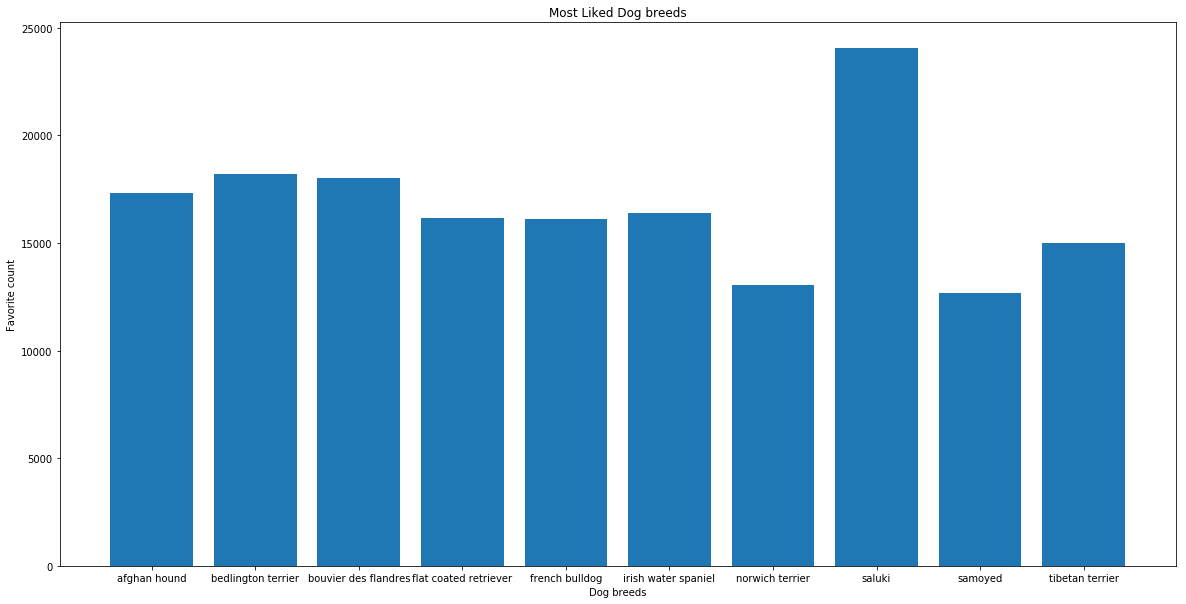

In [99]:
tick_label = list(most_liked_dogs.index)
plt.figure(figsize=(20, 10))
plt.bar(most_liked_dogs.index, most_liked_dogs.favorite_count)
plt.xlabel('Dog breeds')
plt.ylabel('Favorite count')
plt.title('Most Liked Dog breeds')
plt.xticks(tick_label, tick_label)
plt.legend()
plt.show()

> Note:
The most liked dog breed is the `Saluki` with **24k** likes , than comes `bedlington terrier bouvie` &  `bouvier des flandres` with around **18k** likes, than comes other dog breeds such as : 
- `afghan hound` with **17k** likes
- `irish water spaniel`, `flat coated retriever` & `french bulldog` with **16k** likes
- `tibetan terrier` with **14k** likes
- `norwich terrier` with **13k** likes
- `samoyed` with **12k** likes


## The most common tweet time

In [100]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
tweet_times = pd.DataFrame(df.timestamp.dt.hour.value_counts().sort_values(ascending = False))

In [101]:
tweet_times

,timestamp
1,277
0,249
2,209
16,190
3,164
17,159
23,109
18,99
4,95
15,90


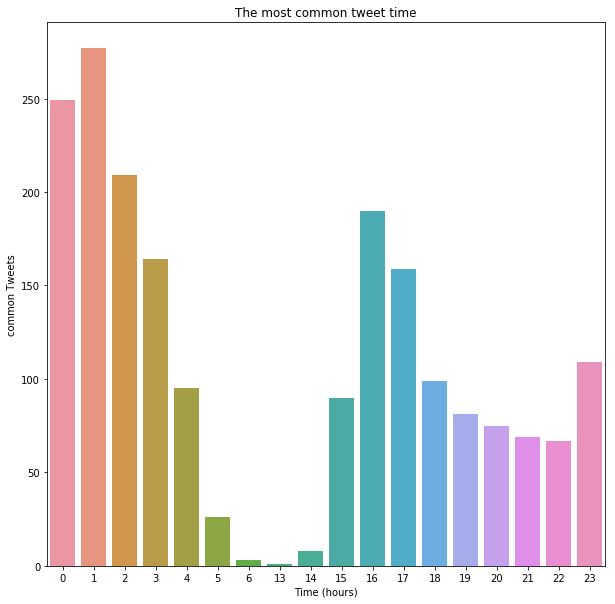

In [102]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x = tweet_times.index, y = tweet_times.timestamp)
ax.set(xlabel='Time (hours)', ylabel='common Tweets')
plt.title('The most common tweet time')
plt.show()

> Note : 
The most common time for tweets is about midnight a.k.a from 00:00am to 3am with **more than 250 tweets** , then it decreases till it becomes nearly 0 active at around 6am.
Noticing that there is a very low activity between 6am to 2pm, where it starts increasing from around 3pm till midnight with **100-200** tweets.

## Most common tweeted dog breeds

In [103]:
most_common_tweeted_dogbreeds = df.dog_breed.value_counts().sort_values(ascending = False).head(10)
most_common_tweeted_dogbreeds

golden retriever            185
chihuahua                   123
labrador retriever          114
pug                          70
pomeranian                   63
siberian husky               59
samoyed                      52
beagle                       45
french bulldog               43
chesapeake bay retriever     42
Name: dog_breed, dtype: int64

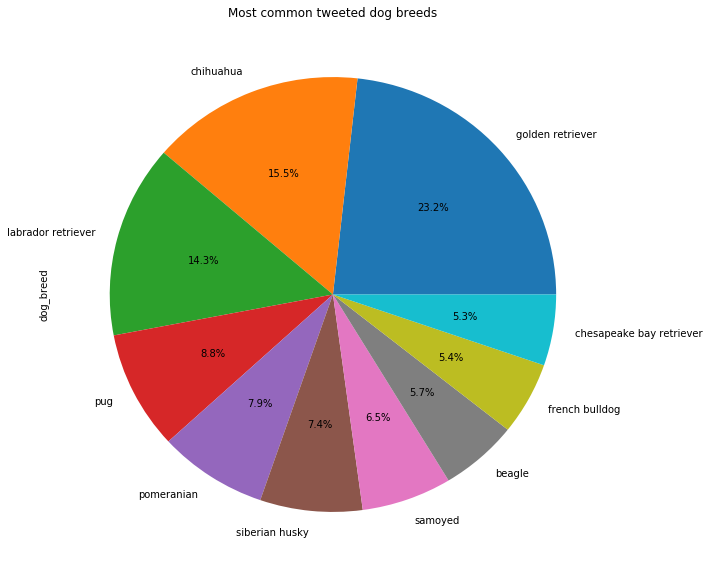

In [104]:
most_common_tweeted_dogbreeds.plot.pie(title = 'Most common tweeted dog breeds',
                                                                             autopct='%1.1f%%', figsize=(10, 10));

> Note : The most common tweeted dog breed is the `golden retriever` breed with **23%** then comes the `chihuahua` breed with **15.15%** tweets of the total.
In the third place comes the  `labrador retriever` breed with **14.3%**
After that we've other dog breeds such us : `pug` `pomeranian` `siberian husky` `samoyed` `beagle` `french bulldog` `chesapeake bay retriever`  with **less than 10%**.

## 10 Highest ranked dog breeds

In [105]:
highest_ranking_dog_breeds = pd.DataFrame(df.groupby('dog_breed')['rating_(x/10)'].mean()).sort_values(by=['rating_(x/10)'], 
                                                                                                       ascending = False).head(10)
highest_ranking_dog_breeds

,rating_(x/10)
dog_breed,
soft coated wheaten terrier,18.250000
kuvasz,16.625000
labrador retriever,13.517544
bouvier des flandres,13.000000
borzoi,12.866667
saluki,12.500000
pomeranian,12.158730
golden retriever,12.043243
tibetan mastiff,12.000000


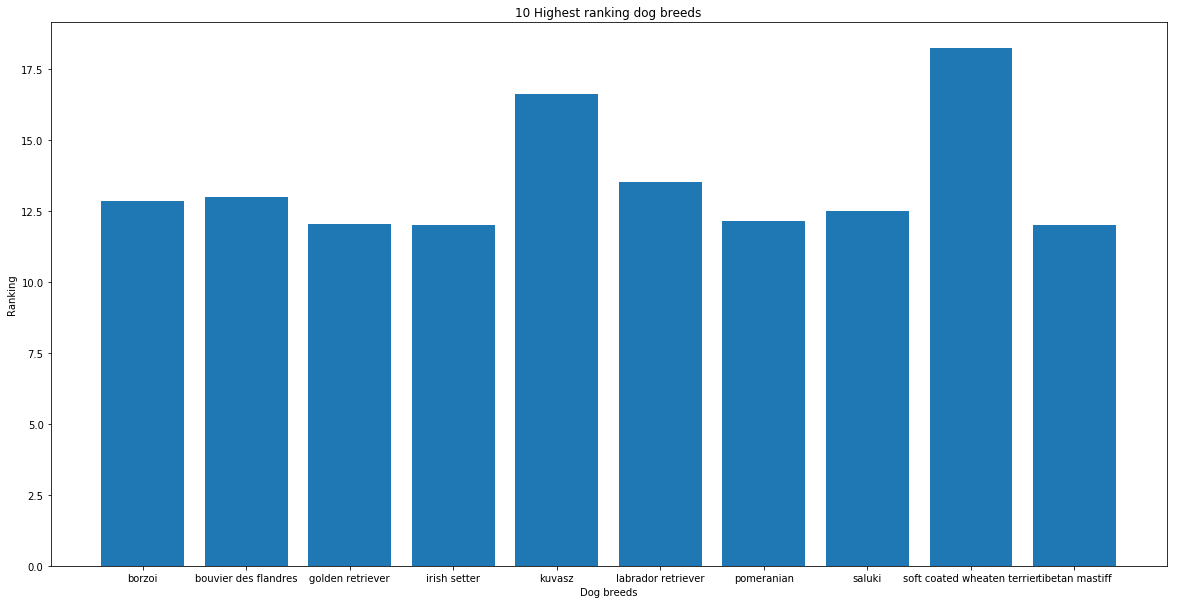

In [106]:
tick_label = list(highest_ranking_dog_breeds.index)
plt.figure(figsize=(20, 10))
plt.bar(highest_ranking_dog_breeds.index, highest_ranking_dog_breeds['rating_(x/10)'])
plt.xlabel('Dog breeds')
plt.ylabel('Ranking')
plt.title('10 Highest ranking dog breeds')
plt.xticks(tick_label, tick_label)
plt.legend()
plt.show()

> Note : The highest ranked dog breed is the `soft coated wheaten terrier` breed with a rating of **18/10**  the comes the  `kuvasz` breed with **16.6/10** and than comes other breeds such us :
- `labrador retriever`  `bouvier des flandres` with a rating of **13/10**
- `borzoi` `saluki` `pomeranian` `golden retriever` `tibetan mastiff` `irish setter` with a rating of **12/10**

## 10 Most retweeted dog breed tweets

In [107]:
Most_retweeted_dog_breed_tweets = pd.DataFrame(df.groupby('dog_breed')['retweet_count'].mean()).sort_values(by=['retweet_count'], 
                                                                                                  ascending = False).head(10)
Most_retweeted_dog_breed_tweets

,retweet_count
dog_breed,
tibetan terrier,6568.875000
bedlington terrier,6473.428571
afghan hound,5976.000000
saluki,5133.750000
irish water spaniel,4500.666667
samoyed,4486.288462
bouvier des flandres,4479.000000
french bulldog,4358.790698
flat coated retriever,4293.888889


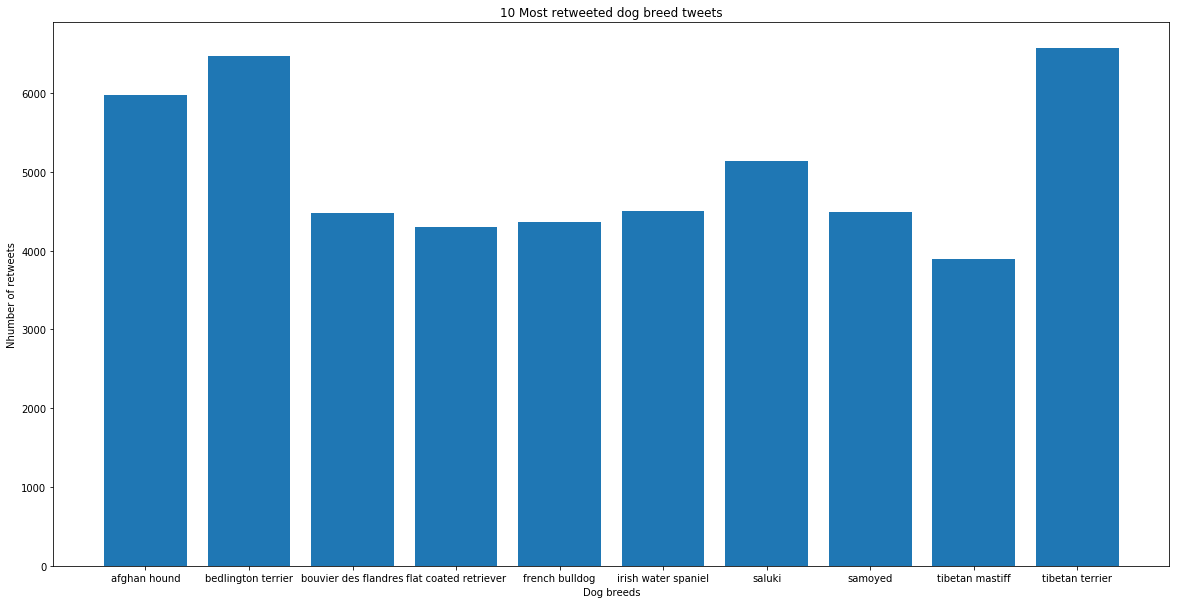

In [108]:
tick_label = list(Most_retweeted_dog_breed_tweets.index)
plt.figure(figsize=(20, 10))
plt.bar(Most_retweeted_dog_breed_tweets.index, Most_retweeted_dog_breed_tweets['retweet_count'])
plt.xlabel('Dog breeds')
plt.ylabel('Nhumber of retweets')
plt.title('10 Most retweeted dog breed tweets')
plt.xticks(tick_label, tick_label)
plt.legend()
plt.show()

> Note : from the graph apove we can see that the most retweeted dog breed is `tibetan terrier` & `bedlington terrier` with about **64k** retweets, then comes `afghan hound` with around **60k** retweets and the `saluki` breed with **50k** retweets.
then comes other dog breeds with an average of **43k** retweets such us :
- `irish water spaniel`
- `samoyed`
- `bouvier des flandres`
- `french bulldog`
- `flat coated retriever`
- `tibetan mastiff`

## Dog step tweets

In [109]:
dog_step_tweet = pd.DataFrame(df.dog_step.value_counts().sort_values(ascending = False))
dog_step_tweet

,dog_step
pupper,201
doggo,73
puppo,22
floofer,7


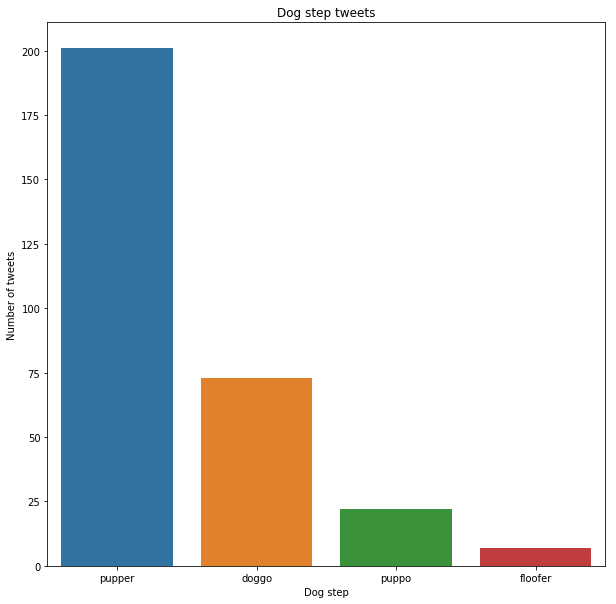

In [110]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x = dog_step_tweet.index, y = dog_step_tweet.dog_step)
ax.set(xlabel='Dog step', ylabel='Number of tweets')
plt.title('Dog step tweets')
plt.show()

> Note : The most tweeted dog step is `pupper` in the **1st** place
then comes in 2nd place `doggo`, and `floofer` in the **3rd** place and finally comes `puppo` in the **4th** and last place


## Dog step retweet

In [111]:
dog_step_retweet = pd.DataFrame(df.groupby('dog_step')['retweet_count'].mean()).sort_values(by=['retweet_count'], 
                                                                                                  ascending = False).head(10)
dog_step_retweet

,retweet_count
dog_step,
doggo,6941.452055
puppo,6473.954545
floofer,4968.714286
pupper,2382.502488


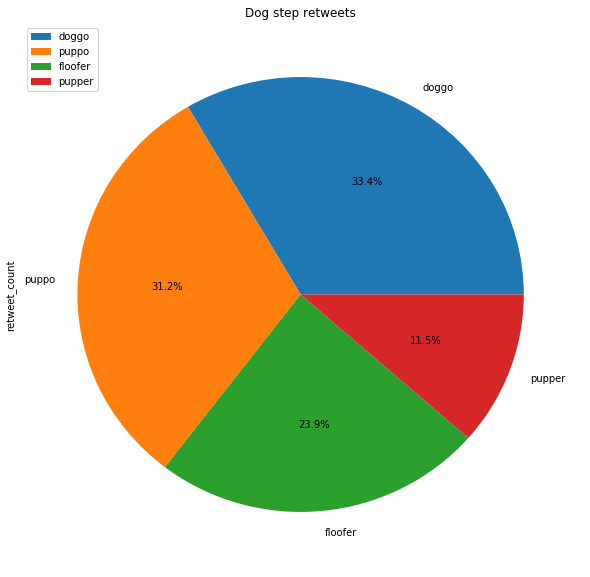

In [112]:
dog_step_retweet.retweet_count.plot.pie(title = 'Dog step retweets',legend=True,autopct='%1.1f%%', figsize=(10, 10));

> Note : The most tweeted dog step is `doggo` in the **1st** place
then comes in **2nd** place `puppo`, and `floofer` in the **3rd** place and finally comes `pupper` in the **4th** and last place

## Dog step likes

In [113]:
dog_step_likes = pd.DataFrame(df.groupby('dog_step')['favorite_count'].mean()).sort_values(by=['favorite_count'], ascending = False).head(10)
dog_step_likes

,favorite_count
dog_step,
puppo,21582.090909
doggo,19044.164384
floofer,13206.000000
pupper,7250.527363


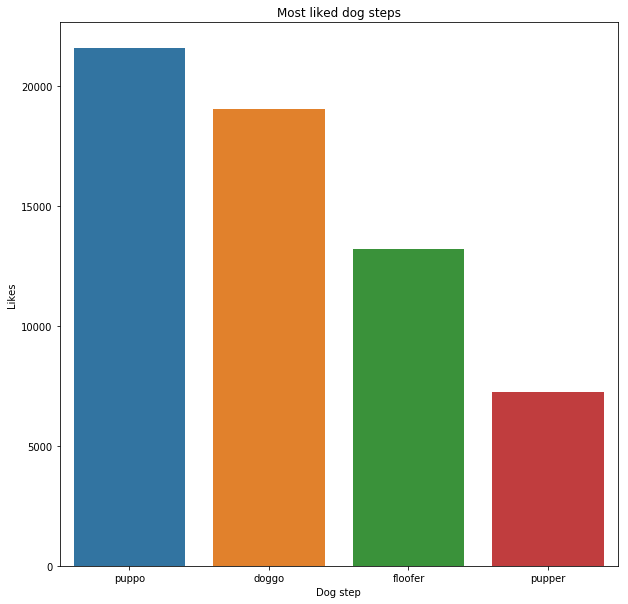

In [114]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x = dog_step_likes.index, y = dog_step_likes.favorite_count)
ax.set(xlabel='Dog step', ylabel='Likes')
plt.title('Most liked dog steps')
plt.show()

> Note : The most liked dog step is `pupper` with **21k** likes in the **1st** place
then comes in **2nd** place `doggo` with **19k**, and `floofer` in the **3rd** place with **13k** and finally comes `pupper` in the **4th** and last place with **7k**